In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


In [3]:
# 自訂 function 可重新 reload
from importlib import reload
from utils import util_inference_result
reload(util_inference_result)
from utils.util_inference_result import *

# I_2

In [4]:
main_folder_path = "/home/hchuang/Documents/Project/"
sub_folder_path = "SSSD_CP/src/results/NYISO_NYC_split/T200_beta00.0001_betaT0.02/"

# folder_path = main_folder_path + "SSSD_CP/src/results/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_I2/"
# pred_data = read_multiple_imputations(folder_path, 1)
# true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

# folder_path = main_folder_path+ "SSSD_CP/src/results/NYISO_4_NYC_split/T200_beta00.0001_betaT0.02/imputaiton_multiple_20k_I2/"
# pred_data = read_multiple_imputations(folder_path, 24)
# true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)

folder_path = main_folder_path+ sub_folder_path+"imputaiton_multiple_130k/"
pred_data = read_multiple_imputations(folder_path, 24)
true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)


print(f"pred_data, shape: {pred_data.shape}")
print(f"true_data, shape: {true_data.shape}")

pred_data, shape: (100, 2209, 1, 24)
true_data, shape: (2209, 1, 24)


In [5]:
L, U = pred_interval(pred_data, beta = 0.05)
E_star = compute_E_star(L, U, true_data, alpha = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)
print(coverage_rate(L, U, true_data))
print(coverage_rate(L_star, U_star, true_data))

[[0.11407877 0.13218651 0.14803078 0.14350385 0.14395654 0.13897691
  0.12992304 0.12494341 0.11090991 0.09868719 0.09280217 0.08963332
  0.08012675 0.08782254 0.08510638 0.07876867 0.0769579  0.08963332
  0.09189679 0.09416025 0.09008601 0.08918062 0.08465369 0.09234948]]
[[0.95020371 0.95020371 0.95020371 0.95020371 0.95020371 0.95020371
  0.95020371 0.95020371 0.95020371 0.95020371 0.95020371 0.95020371
  0.95020371 0.95020371 0.95020371 0.95020371 0.95020371 0.95020371
  0.95020371 0.95020371 0.95020371 0.95020371 0.95020371 0.95020371]]


# Test data

## adjusted pred interval

In [12]:
# folder_path = main_folder_path + "SSSD_CP/src/results/ar1-6/T200_beta00.0001_betaT0.02/imputaiton_multiple_40k_test/"
# pred_data = read_multiple_imputations(folder_path, 1)
# true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 1)

# folder_path = main_folder_path + "SSSD_CP/src/results/NYISO_4_NYC_split/T200_beta00.0001_betaT0.02/imputaiton_multiple_20k_test/"
# pred_data = read_multiple_imputations(folder_path, 24)
# true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)

folder_path = main_folder_path + sub_folder_path+"imputaiton_multiple_test_130k/"
pred_data = read_multiple_imputations(folder_path, 24)
true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)


print(f"pred_data, shape: {pred_data.shape}")
print(f"true_data, shape: {true_data.shape}")

pred_data, shape: (100, 358, 1, 24)
true_data, shape: (358, 1, 24)


In [13]:
L, U = pred_interval(pred_data, beta = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)
print(coverage_rate(L, U, true_data))
print(coverage_rate(L_star, U_star, true_data))

[[0.10893855 0.1424581  0.12290503 0.11731844 0.12011173 0.12011173
  0.10614525 0.12290503 0.11731844 0.10335196 0.05865922 0.08379888
  0.08100559 0.08100559 0.08379888 0.08938547 0.08379888 0.07541899
  0.06703911 0.04189944 0.06424581 0.0698324  0.09497207 0.08100559]]
[[0.94413408 0.92458101 0.91061453 0.90782123 0.91340782 0.91340782
  0.9301676  0.93854749 0.93575419 0.93296089 0.9301676  0.94413408
  0.93575419 0.92178771 0.91620112 0.91620112 0.92178771 0.90782123
  0.91340782 0.90782123 0.91340782 0.9273743  0.92458101 0.91899441]]


## compare to AR(1) theoretical interval

In [106]:
data = np.load('/home/hchuang/Documents/Project/SSSD_CP/src/datasets/AR/test_ar1_1000_3.npy')

In [127]:
def plot_intervals(index, lower_black, upper_black, lower_blue, upper_blue, lower_red, upper_red):
    import matplotlib.pyplot as plt

    # 创建图形和子图
    fig, ax = plt.subplots()
    # 设定 x 轴大小
    ax.set_xlim(-4, 4)  # 设置 x 轴范围为 0 到 10
    ax.set_ylim(0, 2) 
    # 绘制黑色信赖区间
    ax.plot([lower_black, upper_black], [1.5,1.5], color='black', linestyle='-', linewidth=2, label='theoretical')

    # 绘制蓝色信赖区间
    ax.plot([lower_blue, upper_blue], [1,1], color='blue', linestyle='-', linewidth=2, label='SSSD')

    # 绘制红色信赖区间
    ax.plot([lower_red, upper_red], [0.5,0.5], color='red', linestyle='-', linewidth=2, label='conformalized')

    # 设置纵轴刻度为空
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 添加图例
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # 添加标题
    ax.set_title('Comparison of Prediction Intervals' + str(index))

    # 显示图形
    plt.show()


In [128]:
import os

current_directory = os.getcwd()
print("当前工作目录:", current_directory)

当前工作目录: /home/hchuang/Documents/Project/SSSD_CP/src


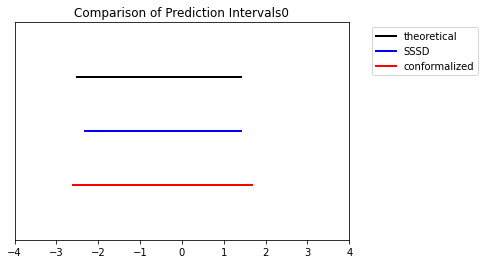

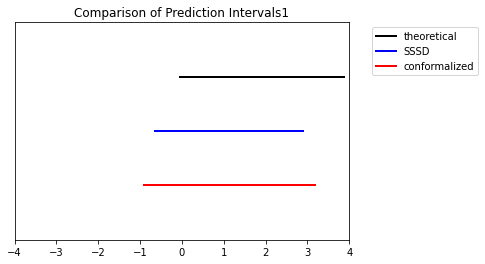

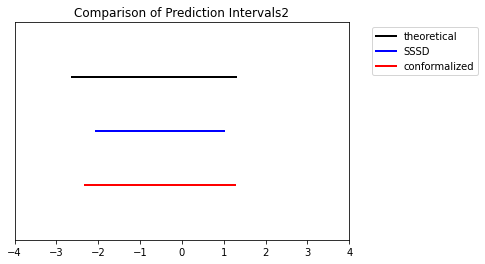

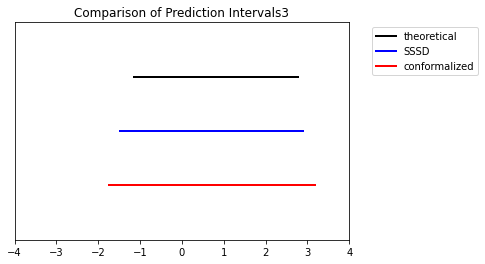

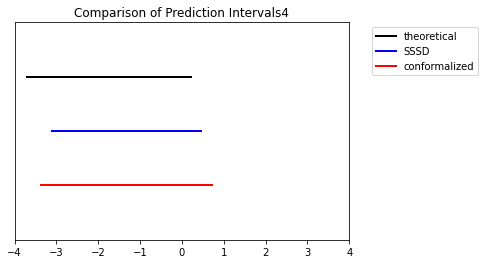

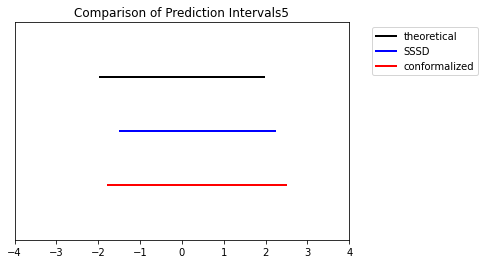

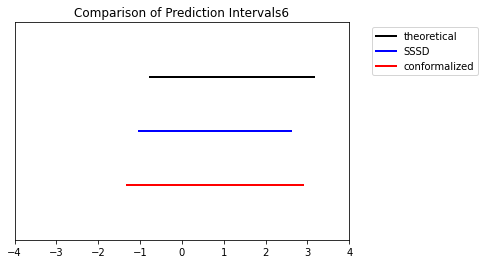

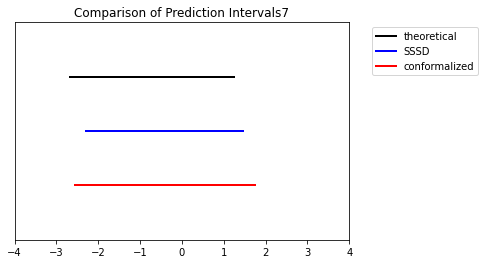

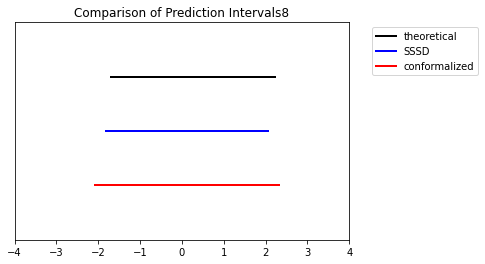

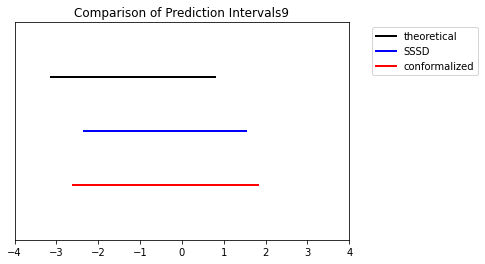

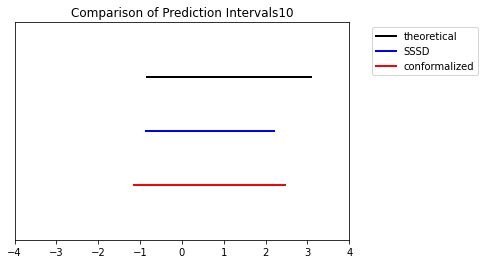

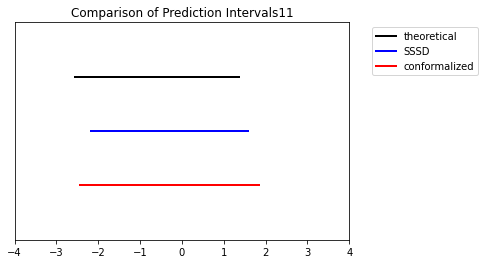

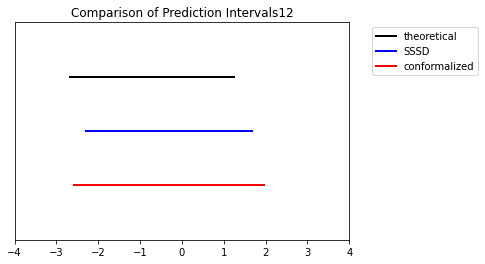

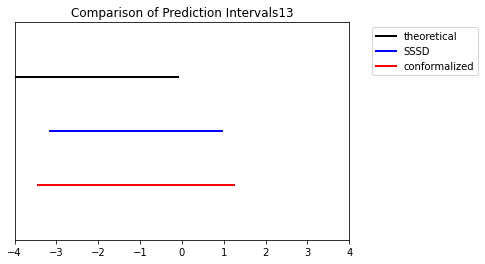

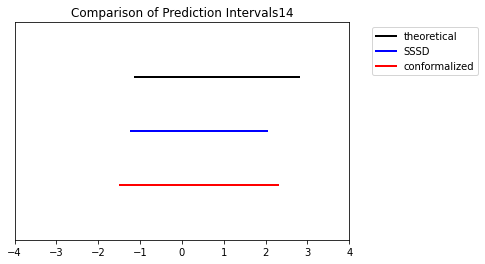

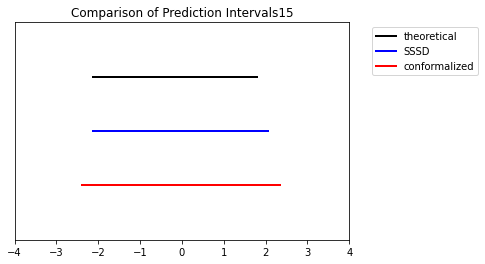

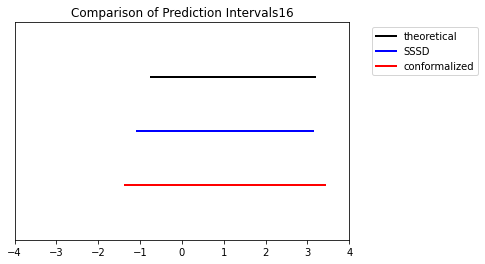

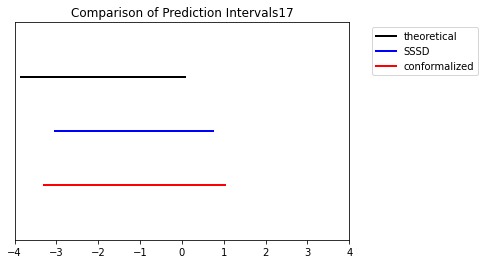

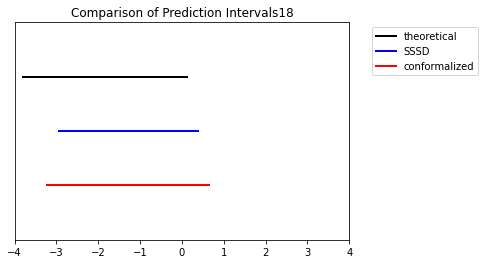

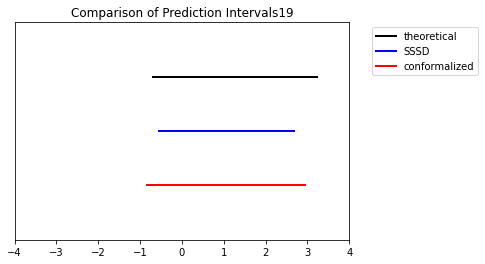

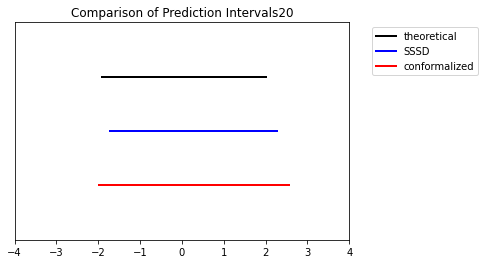

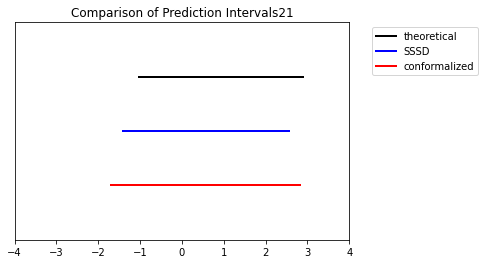

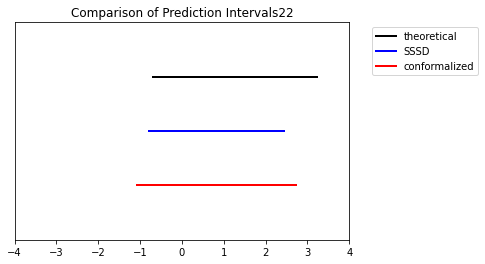

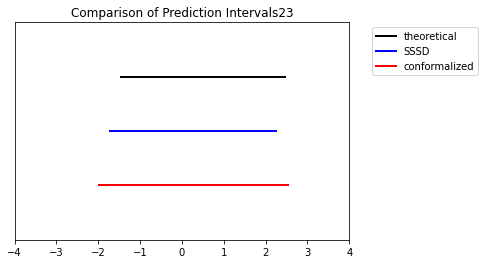

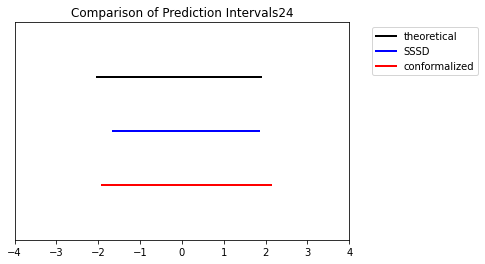

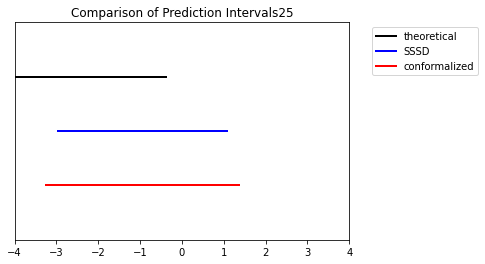

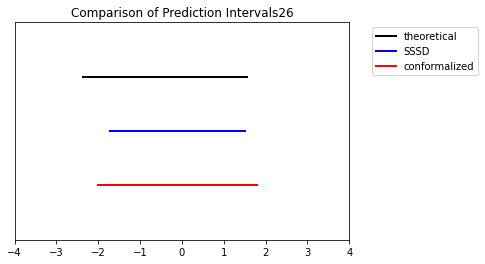

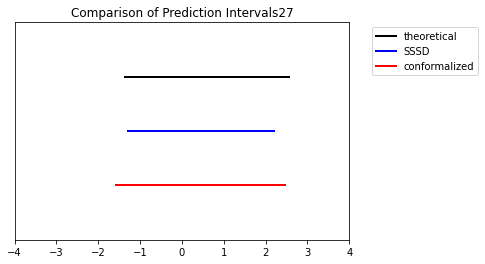

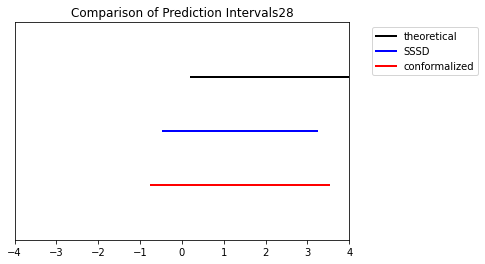

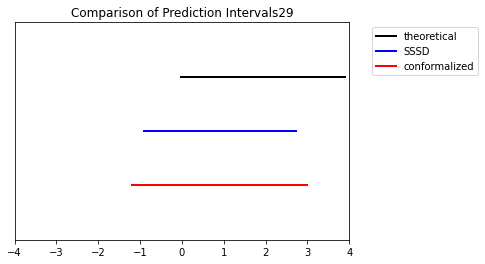

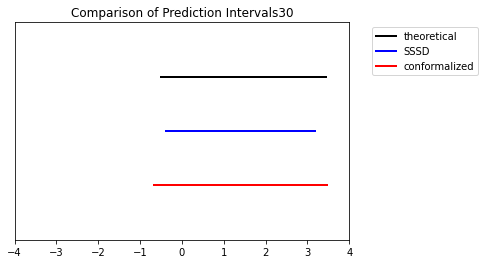

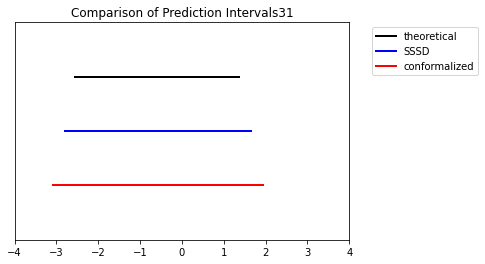

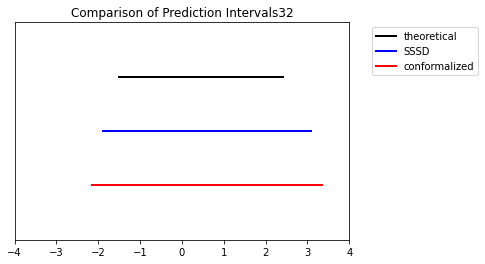

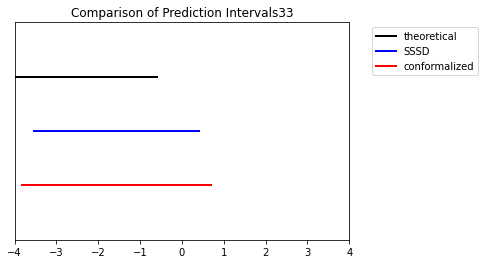

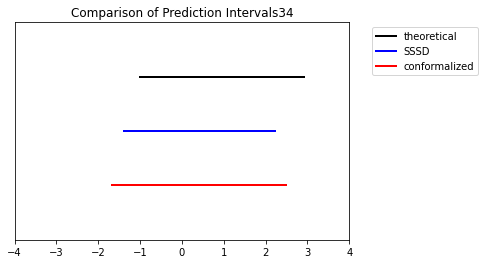

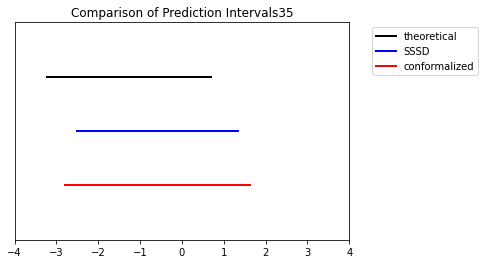

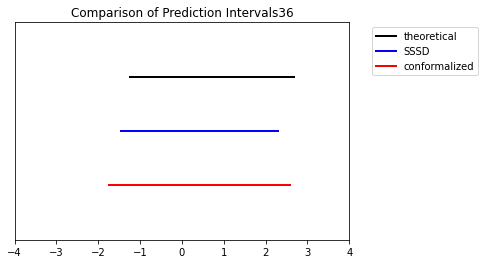

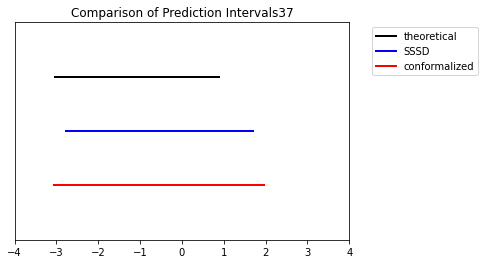

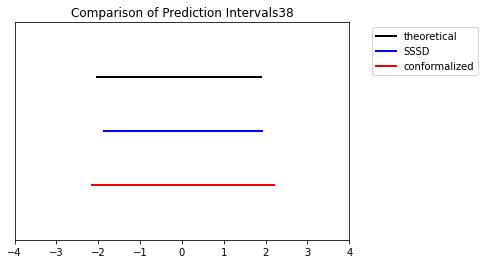

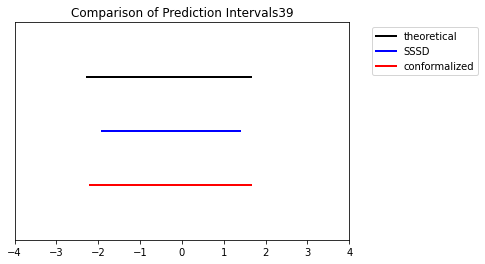

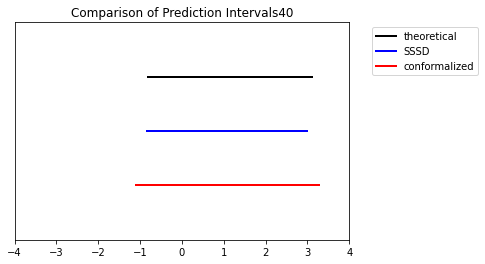

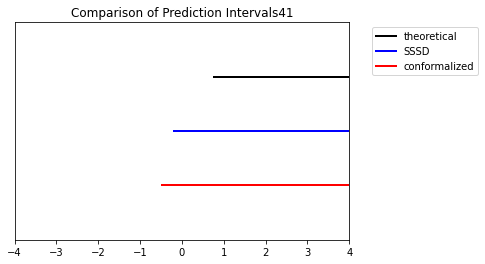

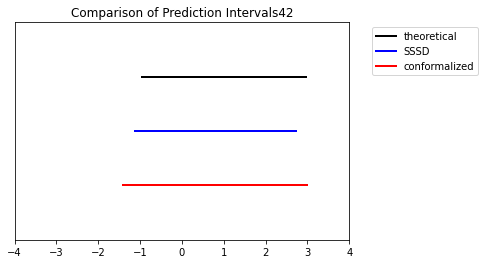

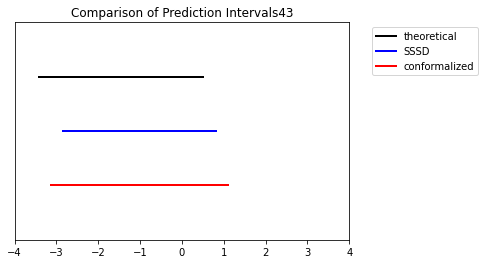

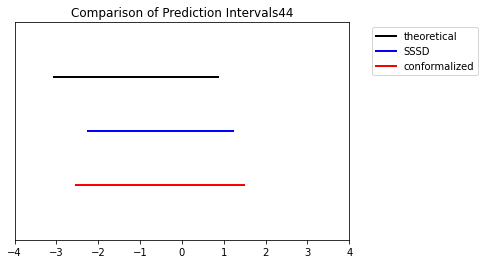

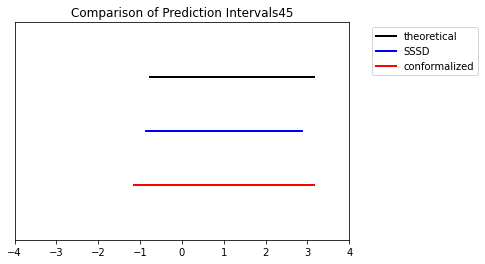

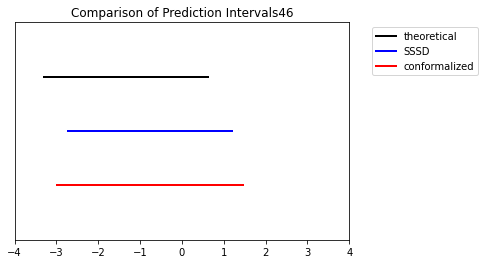

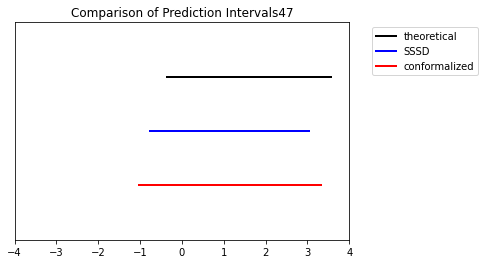

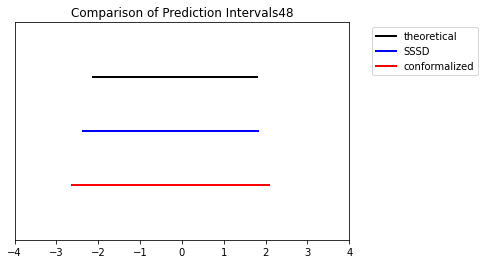

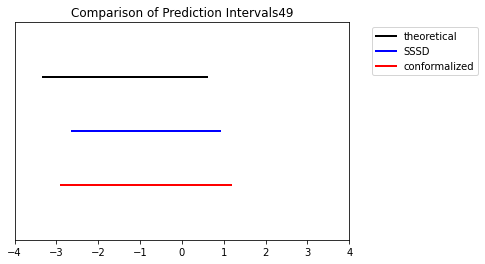

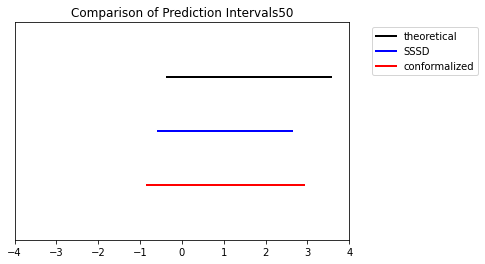

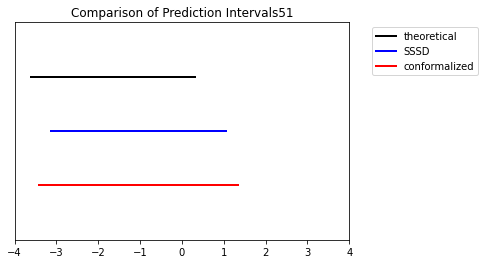

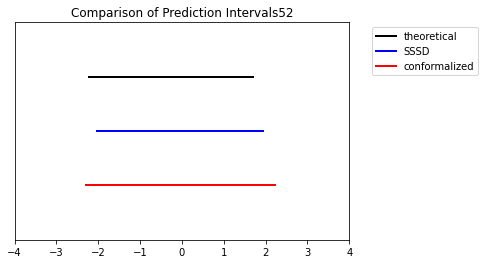

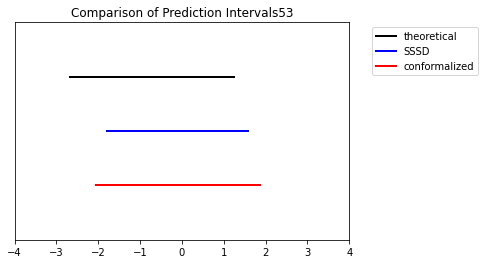

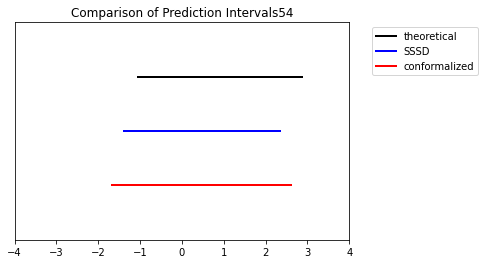

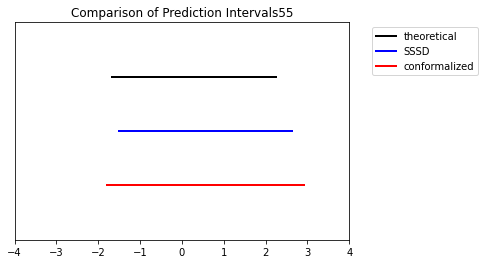

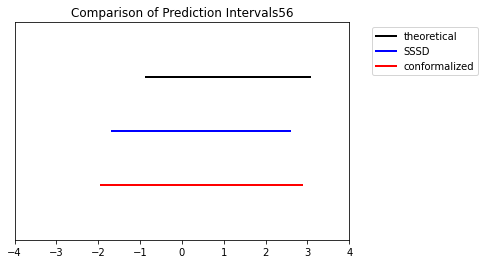

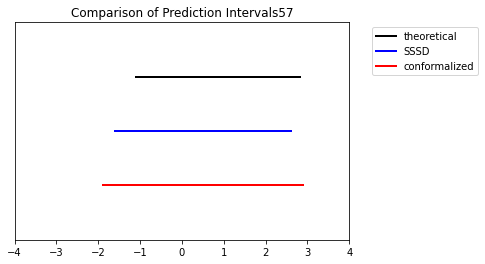

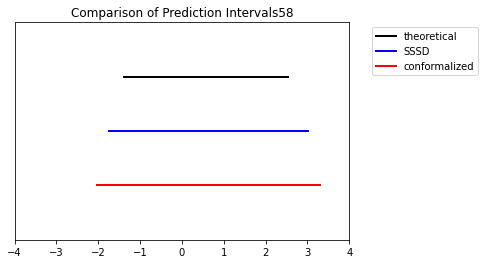

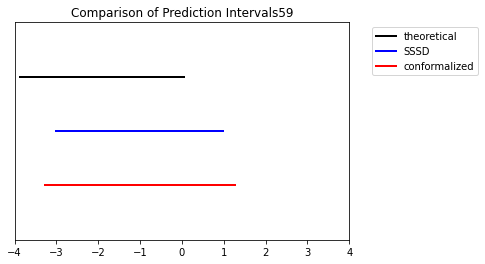

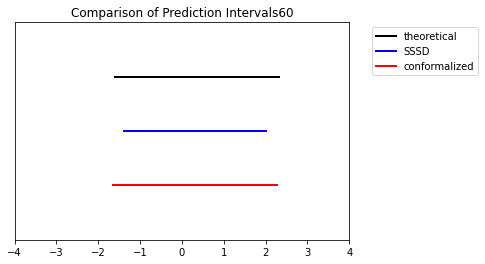

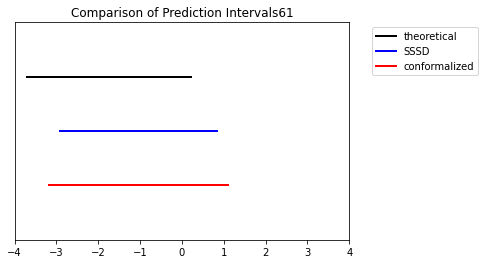

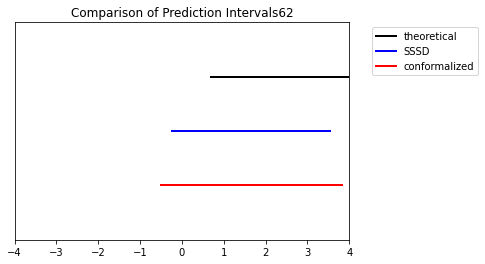

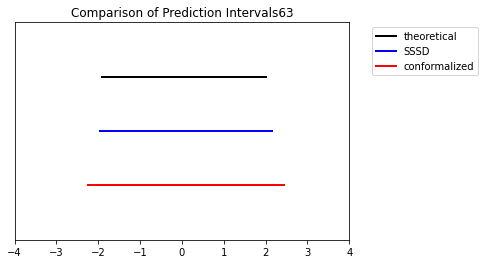

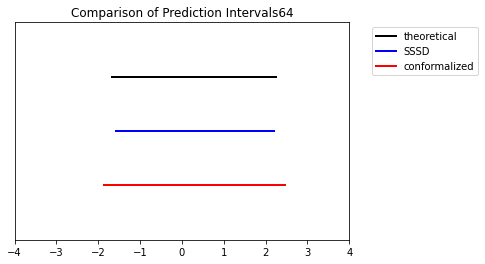

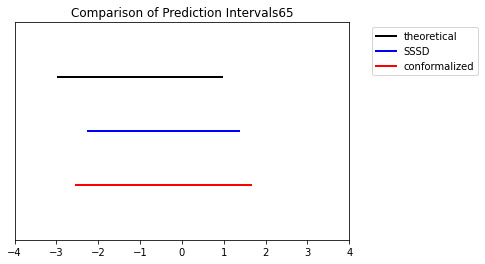

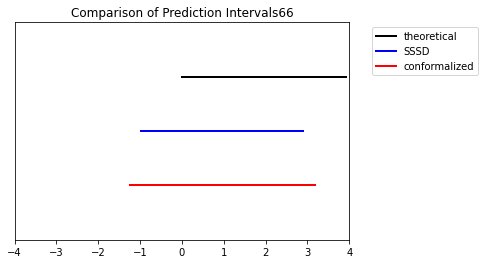

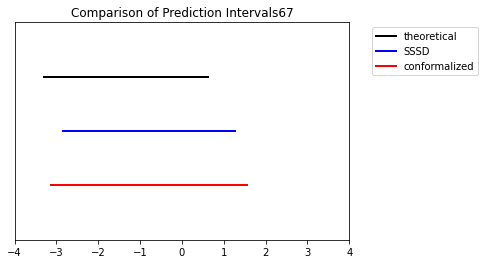

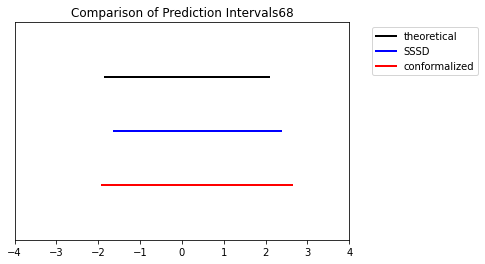

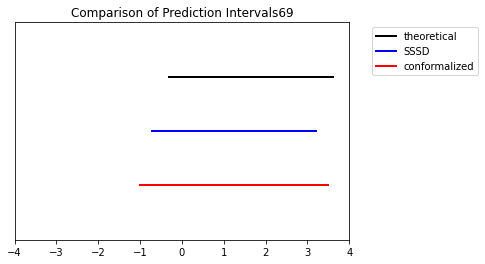

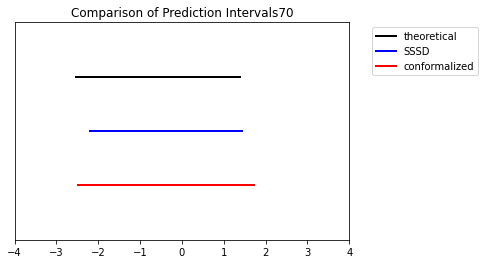

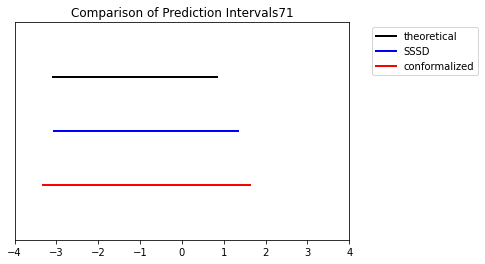

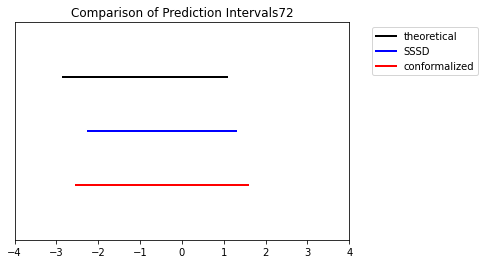

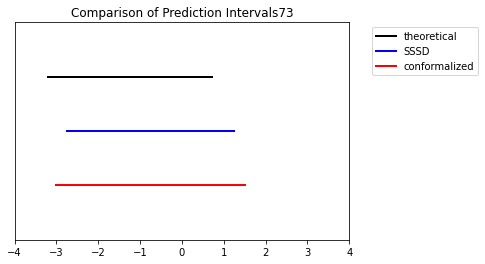

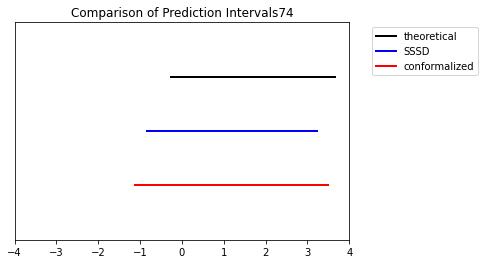

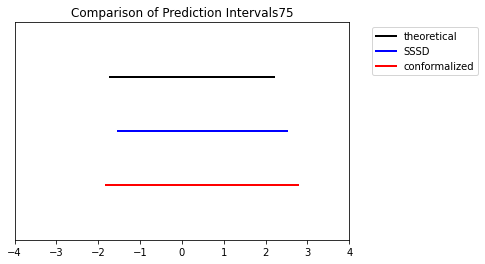

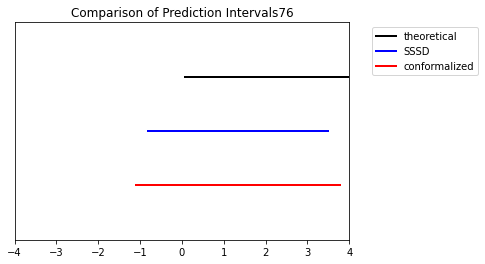

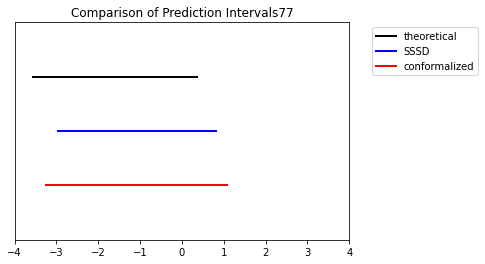

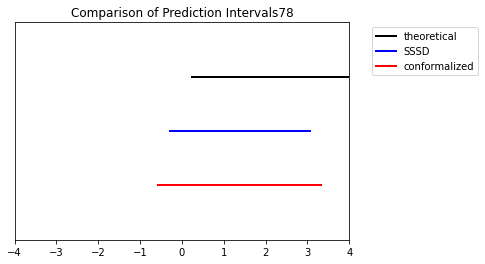

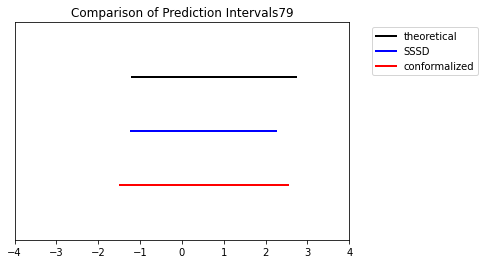

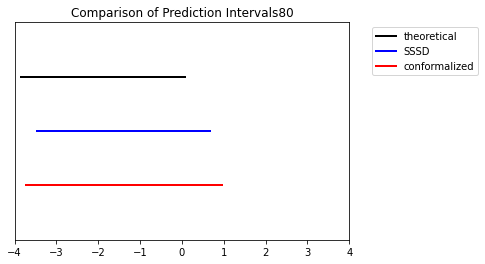

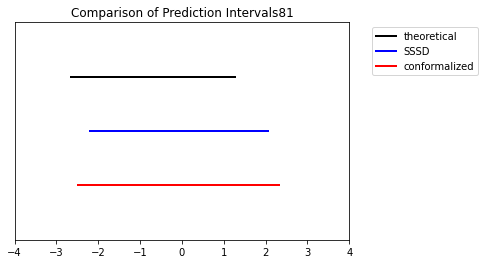

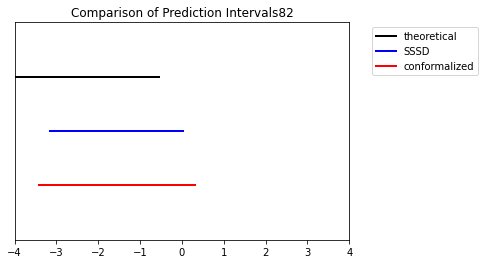

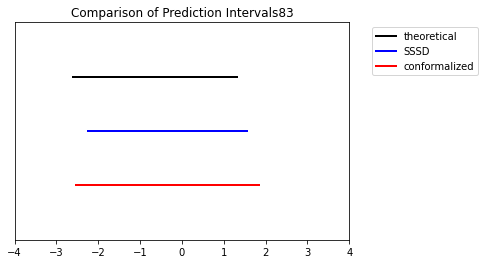

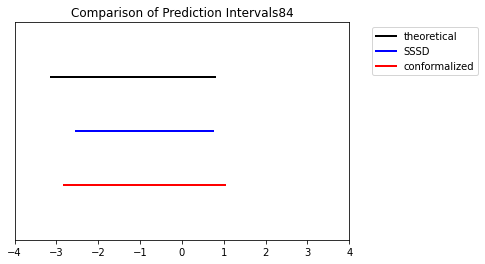

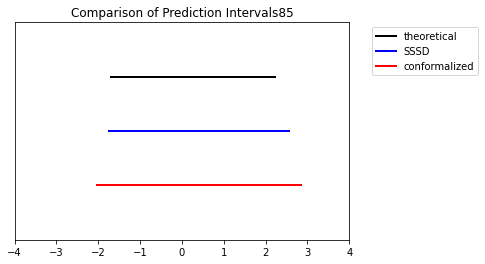

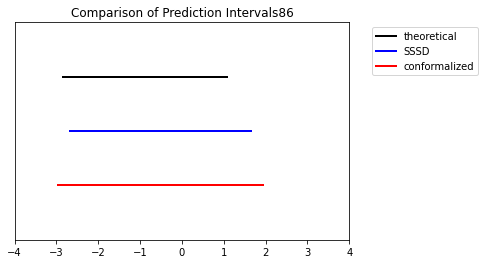

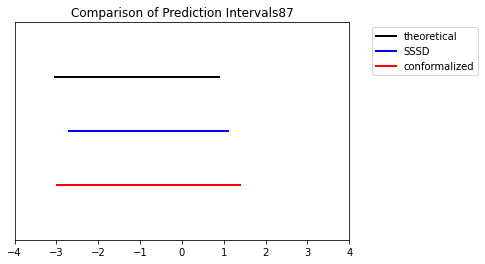

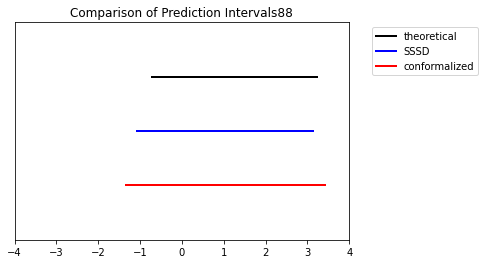

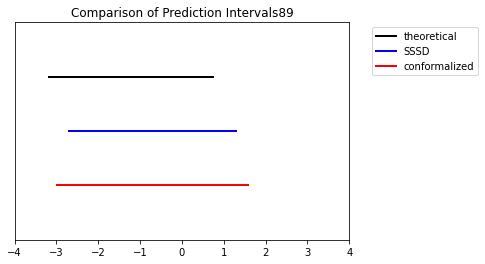

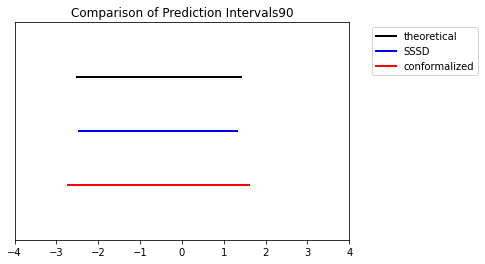

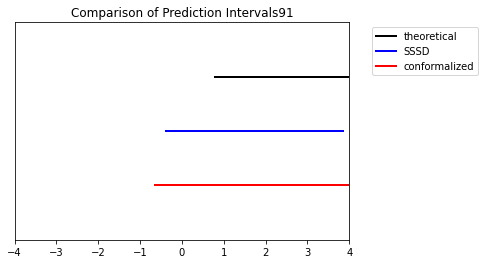

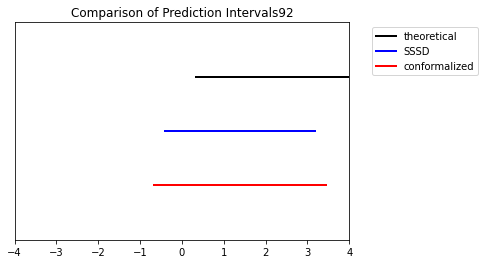

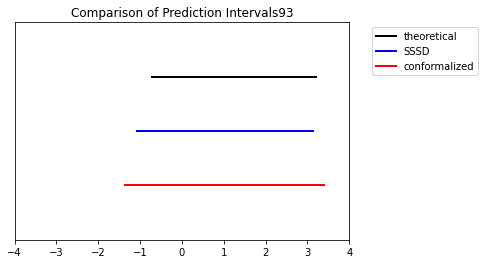

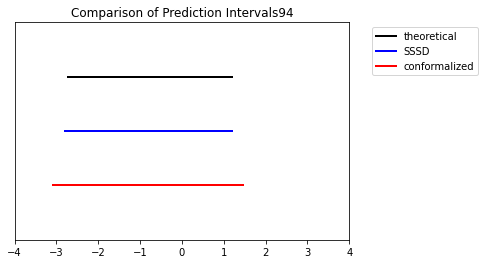

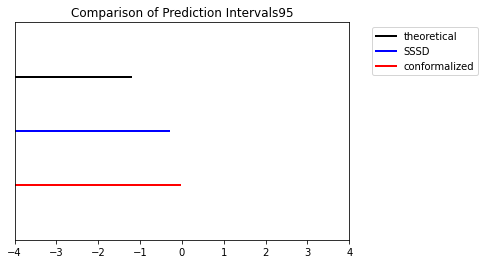

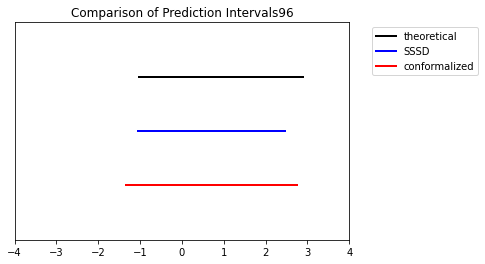

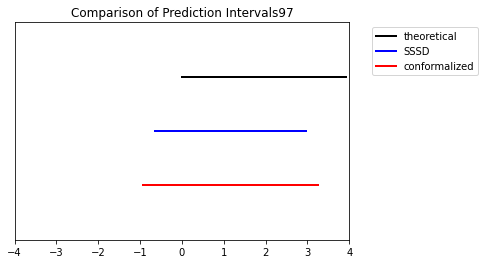

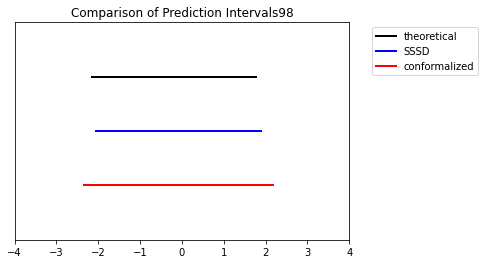

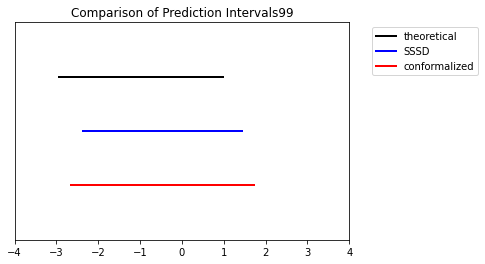

In [129]:
index = 0
for index in range(100):
    plot_intervals(index = index,
                    lower_black = data[index,1,0]*0.8 - 1.96, 
                    upper_black = data[index,1,0]*0.8 + 1.96, 
                    lower_blue = L[index,0,0],
                    upper_blue = U[index,0,0], 
                    lower_red = L_star[index,0,0], 
                    upper_red = U_star[index,0,0])

    # fig.savefig('/home/hchuang/Documents/Project/SSSD_CP/src/results/ar1-6/T200_beta00.0001_betaT0.02/CPI/plot' + str(index) +'.png')  # 可以指定文件名及路径


## vis-NYISO

all_true_data, shape: (358, 1, 192)
2017/01/28


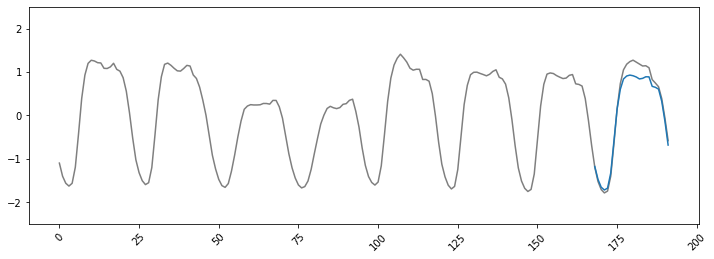

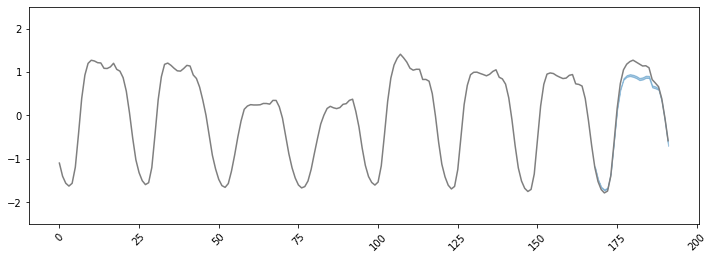

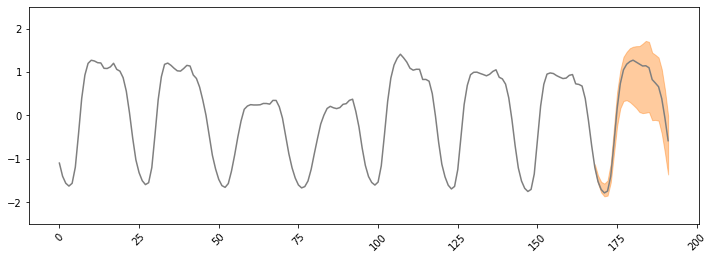

In [15]:
base_time = datetime.strptime("00:00", "%H:%M")
# Create a list of 24 elements by adding 1 hour to the base time in each iteration
hours_sequence = [base_time + timedelta(hours=i) for i in range(24)]
# Format the elements as strings in the desired format (HH:MM)
formatted_sequence = [time.strftime("%H:%M") for time in hours_sequence]

all_true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 192)
print(f"all_true_data, shape: {all_true_data.shape}")

pred_data_mean = np.mean(pred_data,axis=0)


obs = 100
date = generate_date_from_seq(obs)
print(date)
# x = formatted_sequence
x = range(0,192)
y = all_true_data[obs,0,:]
x_predict = range(168, 192)
y_pred_mean = pred_data_mean[obs,0,:]


plt.figure(figsize=(12, 4)) 
plt.plot(x, y, color = 'tab:gray')
plt.plot(x_predict, y_pred_mean, color = 'tab:blue')
# plt.title("mean prediction: " + date)
plt.xticks(rotation=45) 
plt.ylim(-2.5, 2.5) 
plt.show()


lower = L[obs,0,:]
upper = U[obs,0,:]

plt.figure(figsize=(12, 4)) 
plt.plot(x, y, color = 'tab:gray')
# plt.title("original prediction interval: " + date)
plt.xticks(rotation=45) 
plt.fill_between(x_predict, lower, upper, color='tab:blue', alpha=0.4)
plt.ylim(-2.5, 2.5) 
plt.show()

lower = L_star[obs,0,:]
upper = U_star[obs,0,:]

plt.figure(figsize=(12, 4)) 
plt.plot(x, y, color = 'tab:gray')
# plt.title("adjusted prediction interval: " + date)
plt.xticks(rotation=45) 
plt.fill_between(x_predict, lower, upper, color='tab:orange', alpha=0.4)
plt.ylim(-2.5, 2.5) 
plt.show()

In [15]:
# a = cr
# b = cr_star

# # Generate x values (assuming 24 hours)
# x = np.arange(24)

# # Set the width of the bars
# bar_width = 0.35


# # Plotting
# plt.figure(figsize=(10,6))
# plt.bar(x - bar_width/2, a.flatten(), bar_width, label='original')
# plt.bar(x + bar_width/2, b.flatten(), bar_width, label='conformalized')

# # Customize the plot

# plt.xlabel('Hour')
# plt.ylabel('')
# # plt.title('Coverage Rate')
# plt.xticks(x)
# plt.legend(fontsize="14")
# plt.ylim(0, 1.2) 
# plt.axhline(y = 0.95, color = 'black', linestyle = ':') 

# # Show the plot
# plt.show()
